# **Importing the Dataset**

In [2]:
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')

Data source import complete.


#**Import Libraries**



In [3]:
# utils
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# torch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# **Reading The Data**



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device : {device}")

Using device : cpu


In [5]:
#Dataset Paths
base_directory = '/kaggle/input/brain-tumor-mri-dataset'
train, test = 'Training', 'Testing'

In [6]:
#This line of code lists the categories (class folder names) in your training dataset directory.
categories = os.listdir(base_directory+'/'+train)
print(categories)

['pituitary', 'notumor', 'meningioma', 'glioma']


In [7]:
#Converts class names (folder names) into numeric labels for training.
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

In [8]:
#Image & Data Settings (They are not converting images. It's just defining variables for later use.)
target_size = (224, 224)
batch_size = 32
num_classes = 4
random_state = 42

#In machine learning and Python libraries like scikit-learn, using random_state=42 became very common,
#just as a tradition or for fun — it doesn't affect the performance or behavior of the model in any special way.
#You could replace it with any other integer without a problem.


In [9]:
#This function just displays random images from each category in your dataset.
def display_images(dataset_type, num_images=4, image_size=(224, 224)):

    dataset_path = os.path.join(base_directory, dataset_type)

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images

        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()

## **Exploring the Data**

In [10]:
def data_info(dataset_type):
    path = os.path.join(base_directory, dataset_type)

    # Dictionary to store category names and their corresponding image counts
    category_counts = {category: len(os.listdir(os.path.join(path, category))) for category in categories}

    # Calculate the total number of images
    total_images = sum(category_counts.values())

    # Display the category and count
    print(f"Data Information for {dataset_type.capitalize()} Set:\n")
    for category, count in category_counts.items():
        print(f"{category.capitalize()}: {count} images")

    print(f"\nTotal Images: {total_images}")

In [11]:
def plot_class_distribution(dataset_type):
    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bar Chart
    axes[0].bar(categories, counts, color=['navy', 'teal', 'darkorange', 'crimson'])
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Number of Images")
    axes[0].set_title(f"{dataset_type.capitalize()} Set - Bar Chart")

    # Pie Chart
    axes[1].pie(counts, labels=categories, autopct='%1.1f%%', startangle=140, colors=['navy', 'teal', 'darkorange', 'crimson'])
    axes[1].set_title(f"{dataset_type.capitalize()} Set - Pie Chart")

    plt.tight_layout()
    plt.show()


###**Train Set**

In [12]:
data_info(train)

Data Information for Training Set:

Pituitary: 1457 images
Notumor: 1595 images
Meningioma: 1339 images
Glioma: 1321 images

Total Images: 5712


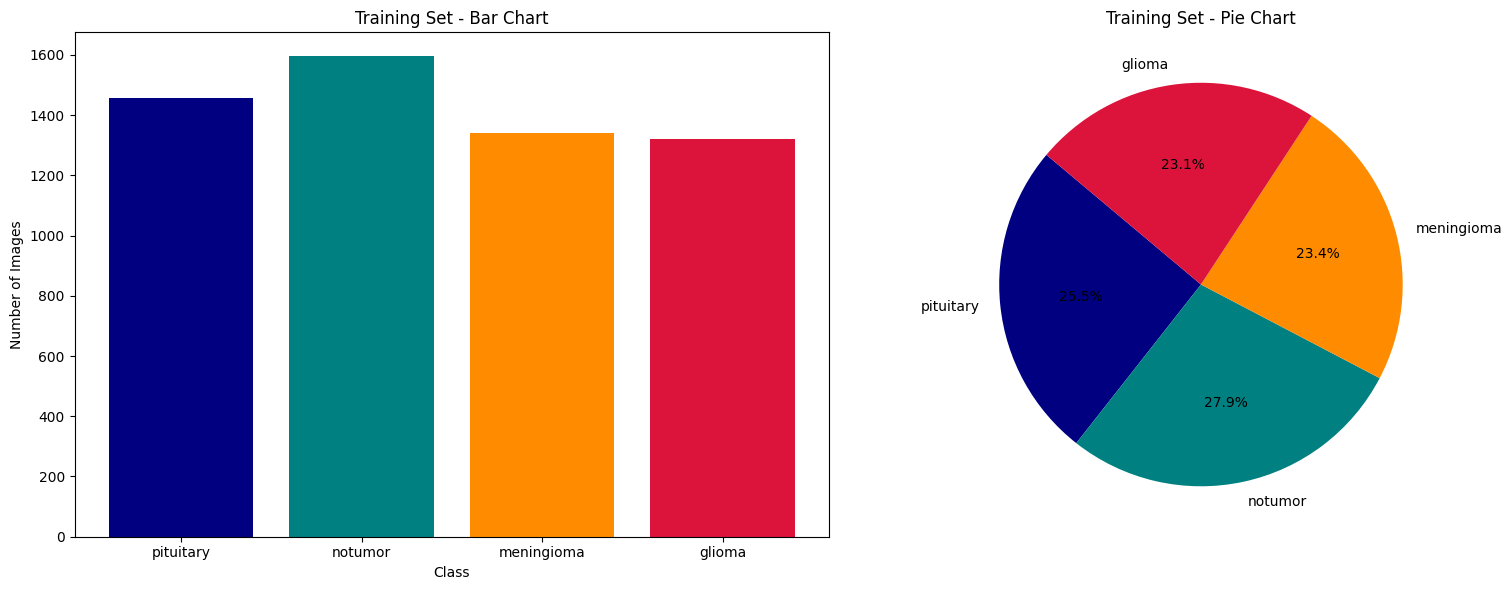

In [13]:
plot_class_distribution(train)

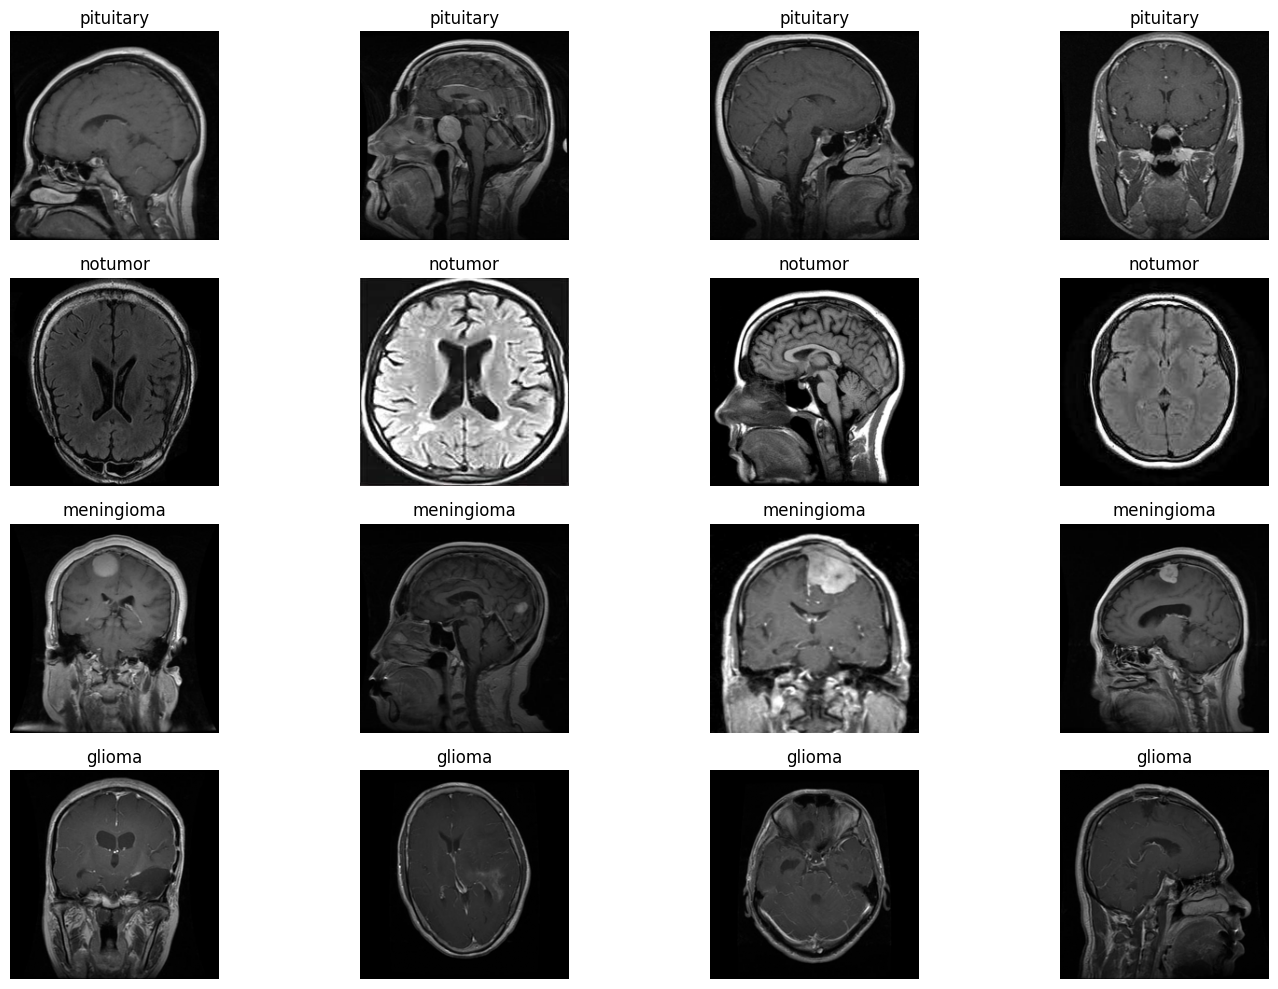

In [14]:
display_images(train)

### **Test Set**

In [15]:
data_info(test)


Data Information for Testing Set:

Pituitary: 300 images
Notumor: 405 images
Meningioma: 306 images
Glioma: 300 images

Total Images: 1311


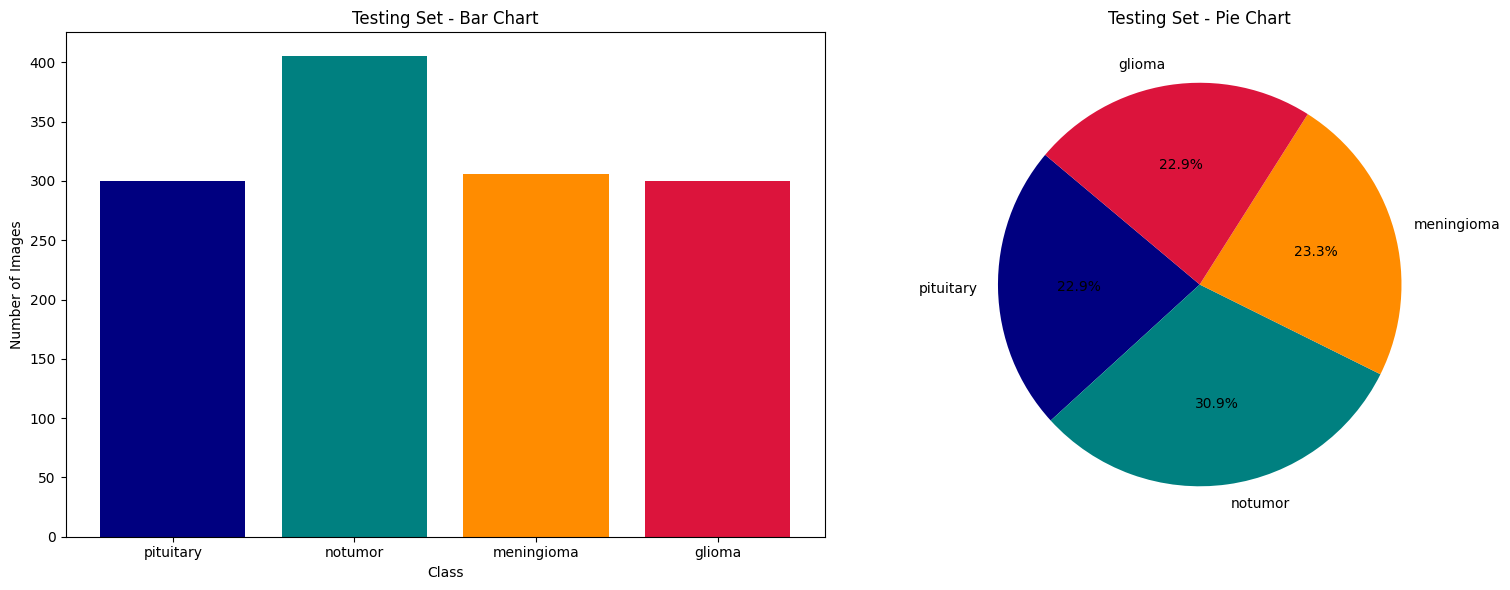

In [16]:
plot_class_distribution(test)

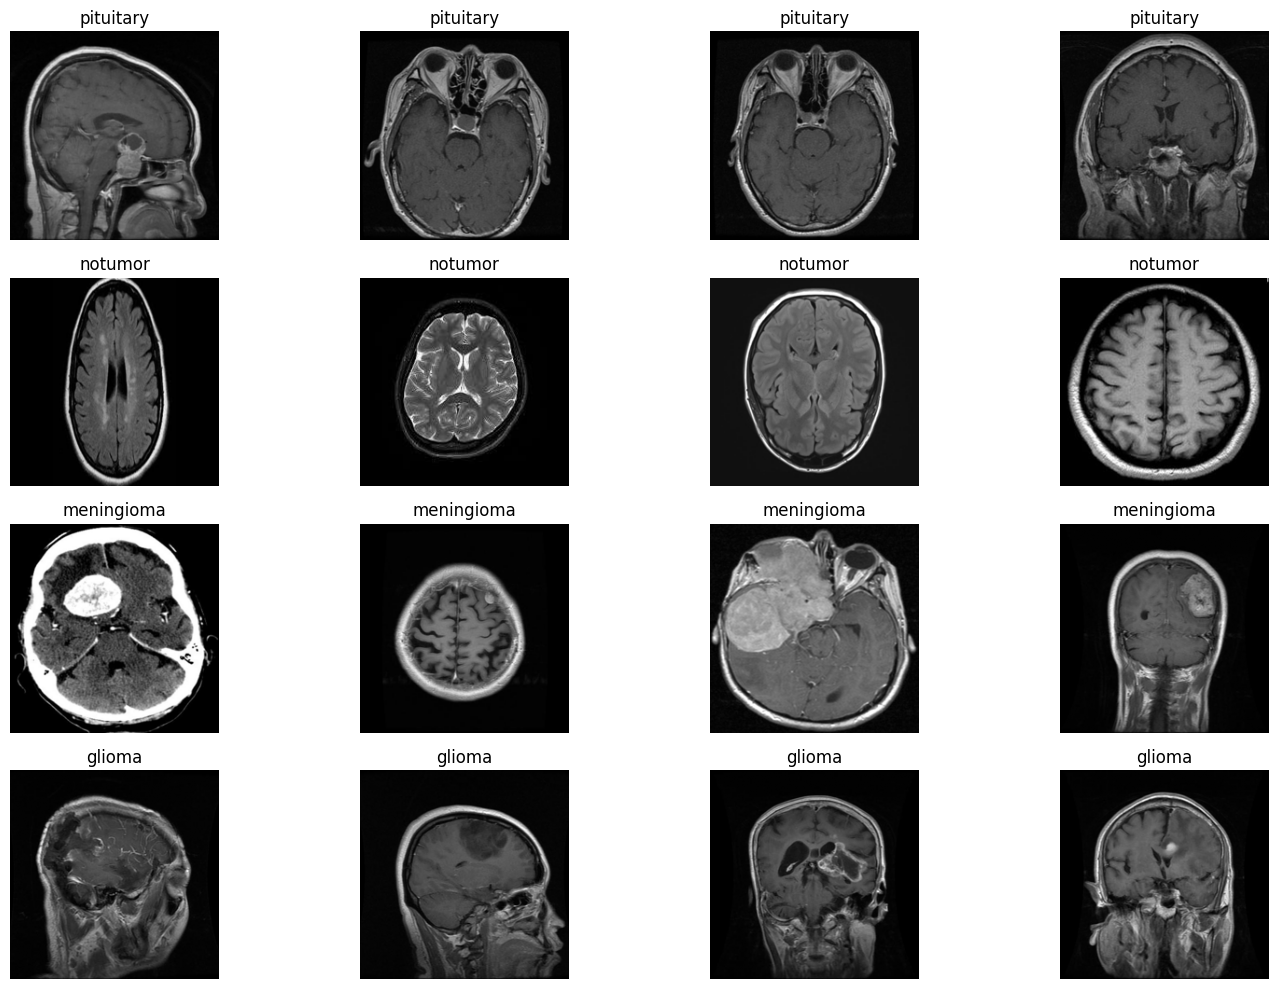

In [17]:
display_images(test)

# **Preparing the Data**

In [18]:
#It collects all the image file paths and their labels into a pandas DataFrame.
#So instead of manually handling folders, we get a clean table like this:
#                  file_path      | label
#---------------------------------------------
# /path/to/glioma/image1.jpg      | glioma
# /path/to/notumor/image2.jpg     | notumor
# /path/to/meningioma/image3.jpg  | meningioma
# /path/to/pituitary/image4.jpg   | pituitary

def create_dataset(path):
    my_list = []
    for category in categories:  #Recall : categories=['pituitary', 'notumor', 'meningioma', 'glioma']
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files (Checks if the path is a file (not a folder) and if the file is an image (by checking its extension).)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [19]:
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test)

In [20]:
train_df.head(4)

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

In [21]:
#Recall : label_map = {'notumor': 0,'glioma': 1,'meningioma': 2,'pituitary': 3}

train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

In [22]:
train_df.head(4)

file_path  label
0  /kaggle/input/brain-tumor-mri-dataset/Training...      3
1  /kaggle/input/brain-tumor-mri-dataset/Training...      3
2  /kaggle/input/brain-tumor-mri-dataset/Training...      3
3  /kaggle/input/brain-tumor-mri-dataset/Training...      3

##**Create Class ImageDataset**

In [23]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB') #convert grayscale images to RGB

        if self.transform: #If transform is provided (i.e., it's not None), then transformations will be applied to the image.
            img = self.transform(img)
            #The line train_transform(img) applies the series of transformations that you defined in train_transform to the input image img.
            #It processes the image step-by-step through each transformation in the list.

        return img, label

## **Data Augmentation**

In [24]:
#Training Dataset ==> Resize + Augment + Normalize
#[train_transform makes model strong]

train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), #Slightly shift images randomly (translation).Each image is randomly shifted differently.
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normalization brings mean close to 0 and variance close to 1 across all channels.
])

# Note:
# ToTensor() converts image to PyTorch Tensor and also converts pixel values to [0, 1].
# Normalize(mean, std) adjusts these pixel values to have zero mean and unit variance, which helps improve model performance and training speed.


#Testing Dataset ==> Resize + Normalize (No Augmentation)
#[test_transform keeps evaluation fair]

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## **Train, Validation and Test Split**

In [25]:
# Our goal :
# Original data (100%)
#  ├── train_df (80%)
#  │      ├── train_df_split (80% of 80%)
#  │      └── val_df_split (20% of 80%)
#  └── test_df (20%)


# 80% of train_df becomes train_df_split (real training data) and 20% of train_df becomes val_df_split (validation data)
train_df_split, val_df_split = train_test_split(train_df, train_size=0.8, random_state=random_state)

# Reset indices for consistency (Resets row numbering (index) starting from 0, and drops old index to keep things clean.)
train_df_split = train_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [26]:
train_dataset = ImageDataset(train_df_split, transform=train_transform) #Now train_dataset is an object of the class ImageDataset that stores all my training images + their labels + how to transform them
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df, transform=test_transform)

# DataLoader = smart batch-maker from a Dataset.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #Shuffle after every epoch (good for training)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def analyze_dataset(dataloader, categories, split_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Count classes
    class_count = {category: 0 for category in categories}
    all_images = []
    all_labels = []

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            class_count[categories[label]] += 1
            all_images.append(img)
            all_labels.append(label)

    # Table with total
    df = pd.DataFrame({split_name: pd.Series(class_count)})
    total_samples = df[split_name].sum()
    df.loc['Total'] = total_samples

    print(f"\n{split_name} Class Distribution Table:\n")
    display(df)

    # Bar plot and Pie chart side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Bar Plot
    sns.barplot(x=df.index[:-1], y=df[split_name][:-1], ax=axs[0])
    axs[0].set_title(f'{split_name} Set Class Distribution')
    axs[0].set_ylabel('Number of Samples')
    axs[0].set_xlabel('Class')
    axs[0].tick_params(axis='x', rotation=45)

    # Pie Chart
    axs[1].pie(df[split_name][:-1], labels=df.index[:-1], autopct='%1.1f%%', startangle=140)
    axs[1].set_title(f'{split_name} Set Distribution')

    plt.tight_layout()
    plt.show()


In [ ]:
def show_sample_images(dataloader, categories, num_samples=10):
    all_images = []
    all_labels = []

    # Collect all images and labels from the dataloader
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            all_images.append(img)
            all_labels.append(label.item())  # Convert tensor to int

    # Plotting sample images
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        idx = random.randint(0, len(all_images)-1)
        img = all_images[idx]
        label = categories[all_labels[idx]]
        img = img.permute(1, 2, 0)  # (C,H,W) to (H,W,C)

        # Normalize image to [0, 1] range
        img = (img - img.min()) / (img.max() - img.min())

        # Organize into a 2x5 grid
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


#### **Train Set (Updated)**


Train Class Distribution Table:



Train
pituitary    1297
notumor      1052
meningioma   1083
glioma       1137
Total        4569

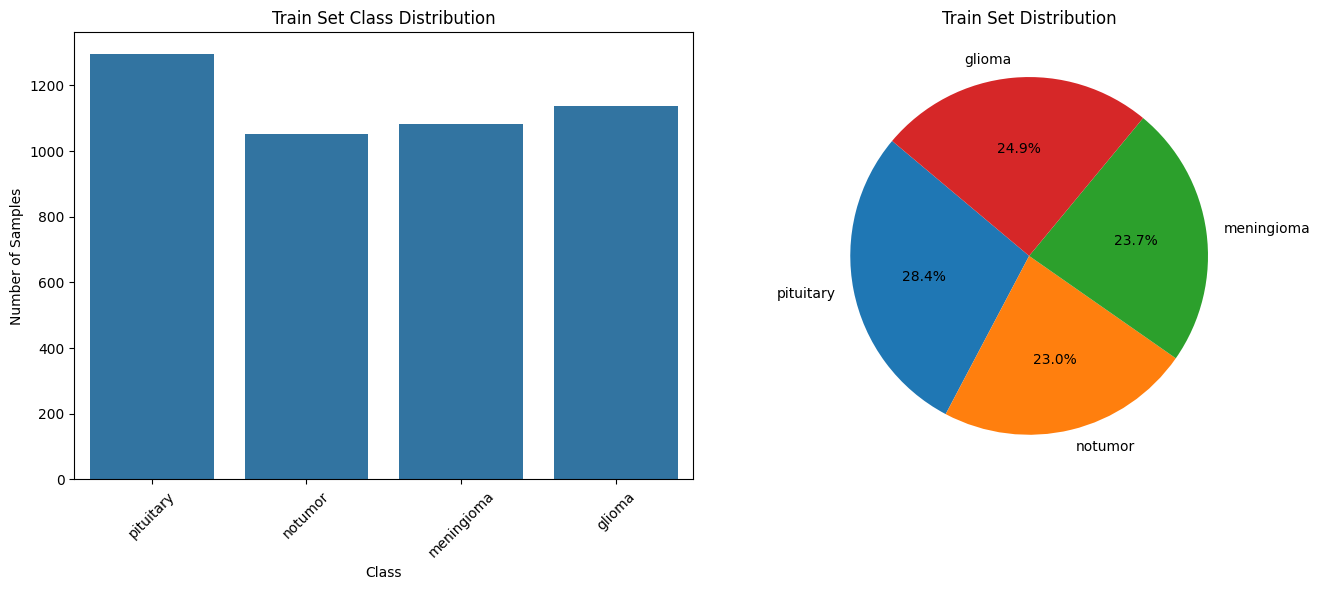

In [ ]:
analyze_dataset(train_loader, categories, split_name="Train")

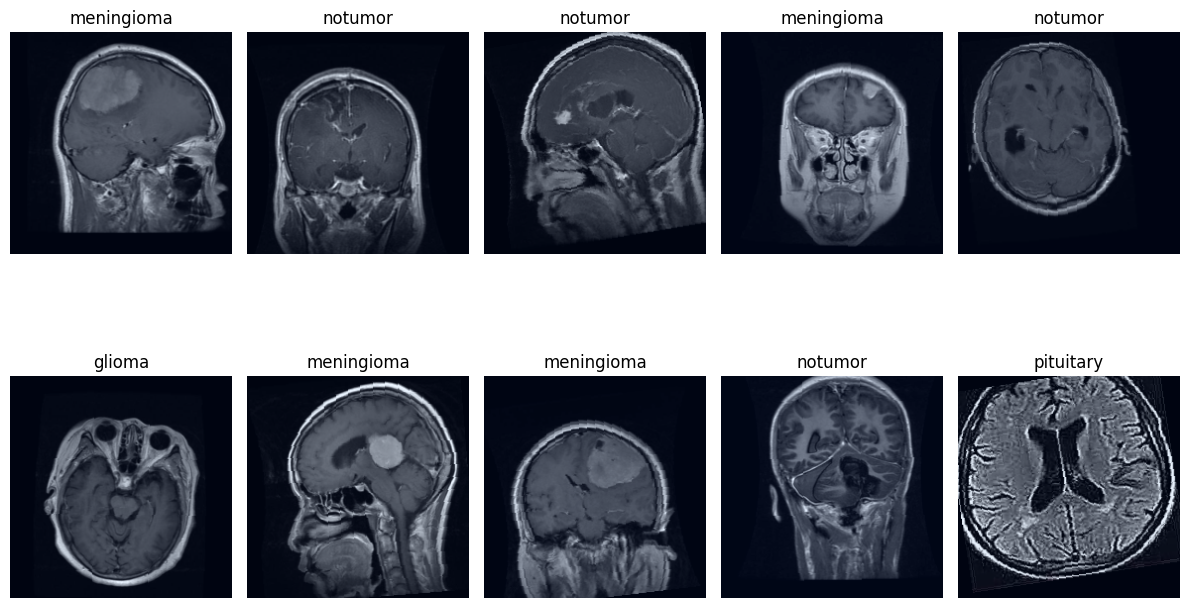

In [ ]:
show_sample_images(train_loader, categories, num_samples=10)  # For train set

#### **Validation Set**


Validation Class Distribution Table:



Validation
pituitary          298
notumor            269
meningioma         256
glioma             320
Total             1143

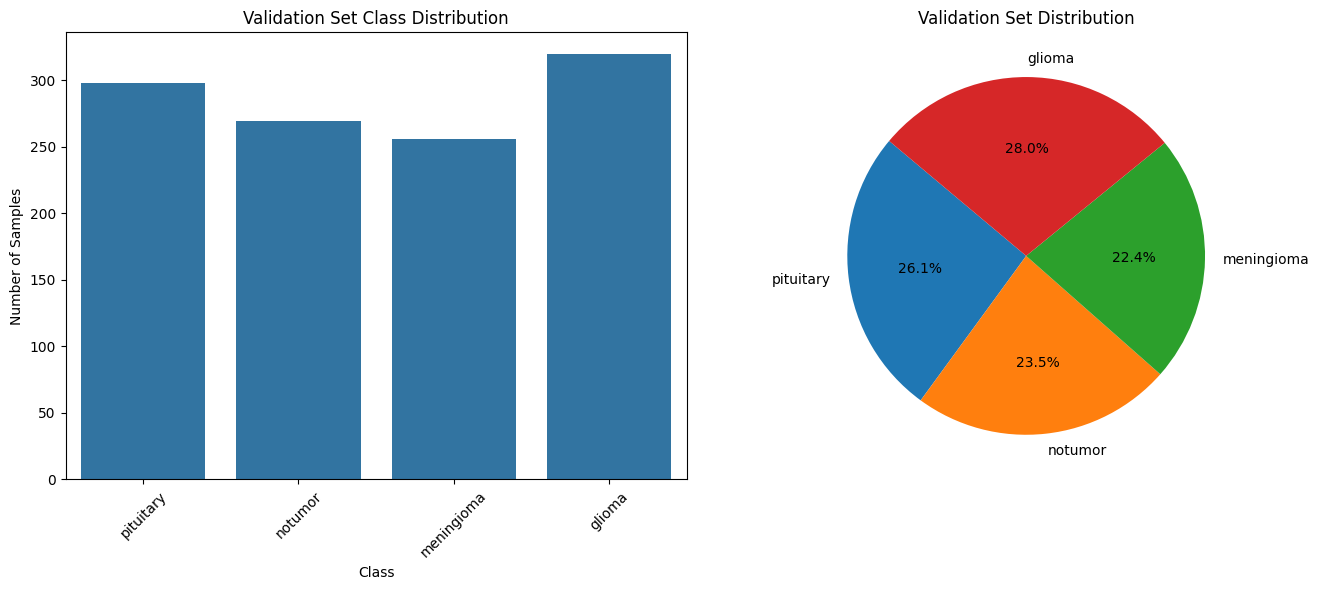

In [ ]:
analyze_dataset(val_loader, categories, split_name="Validation")

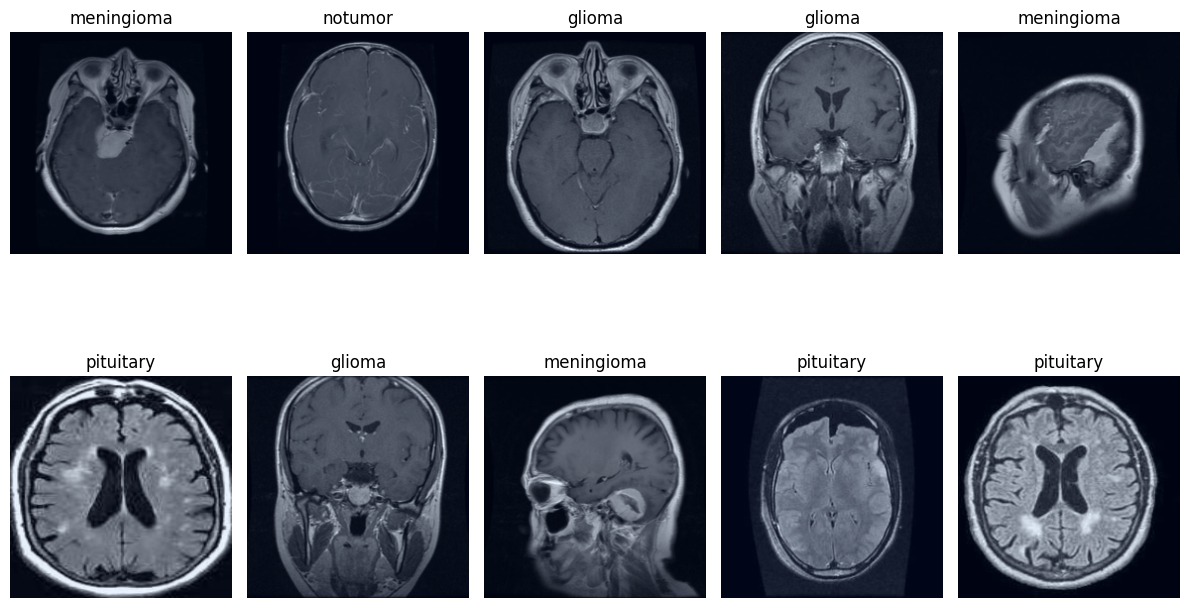

In [ ]:
show_sample_images(val_loader, categories, num_samples=10)  # For validation dataset

#### **Test Set**


Test Class Distribution Table:



Test
pituitary    405
notumor      300
meningioma   306
glioma       300
Total       1311

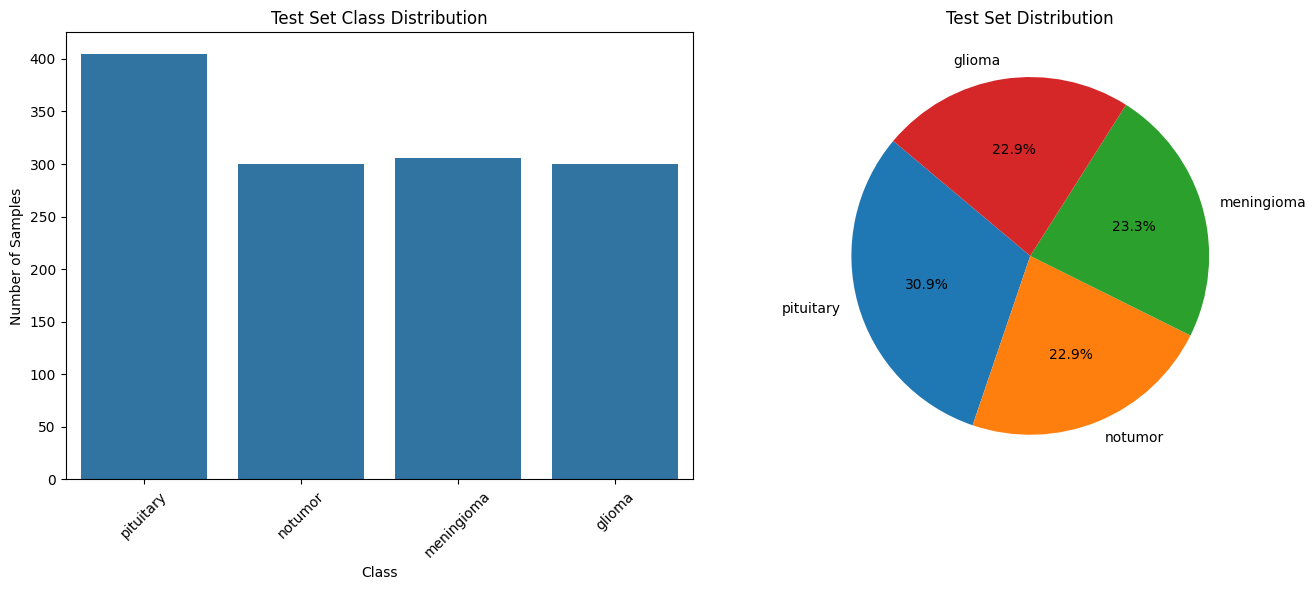

In [ ]:
analyze_dataset(test_loader, categories, split_name="Test")

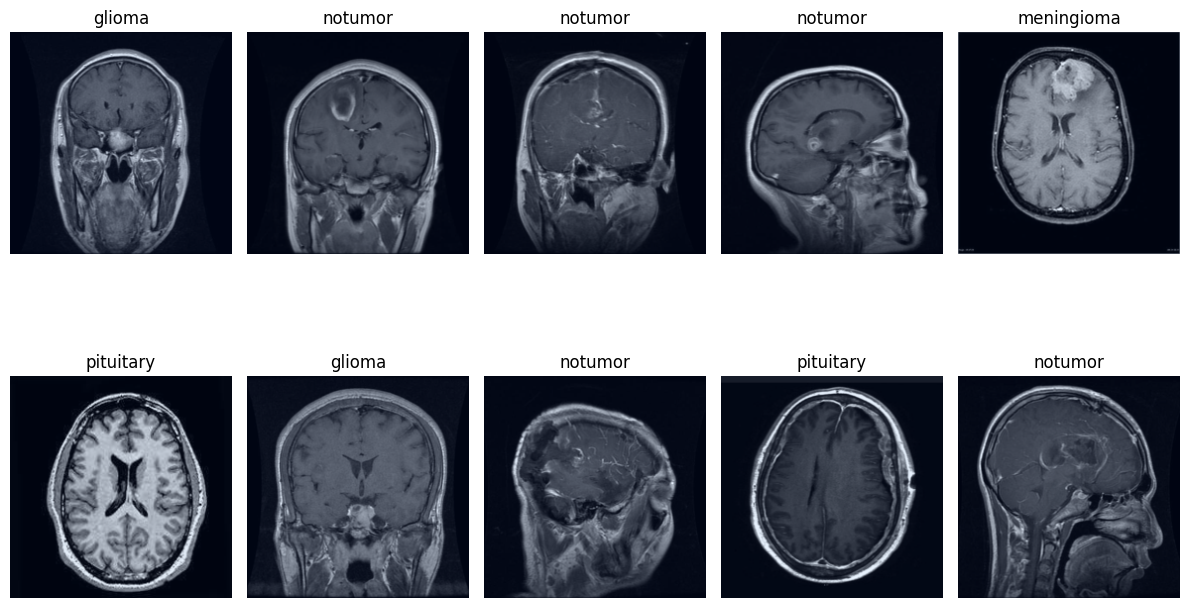

In [ ]:
show_sample_images(test_loader, categories, num_samples=10)  # For test dataset

# **Model 1 (Custom CNN)**

In [38]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B, 32, 224, 224)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 112, 112)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 56, 56)

        # Conv Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (B, 256, 28, 28)

        # Conv Block 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # (B, 256, 14, 14)

        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (B, 32, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 256, 7, 7)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [39]:
model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss() #This is the loss function used for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

## **Model Summary**

In [40]:
!pip install torchinfo
from torchinfo import summary

summary(model,
        input_size=(32, 3, 224, 224),  # Batch size 32, 3 channels (RGB), 224x224 image
        col_names=["kernel_size", "input_size", "output_size", "num_params"],
        depth=3)  # Increase depth to see nested layers

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
BrainTumorCNN                            --                        [32, 3, 224, 224]         [32, 4]                   --
├─Conv2d: 1-1                            [3, 3]                    [32, 3, 224, 224]         [32, 32, 224, 224]        896
├─ReLU: 1-2                              --                        [32, 32, 224, 224]        [32, 32, 224, 224]        --
├─MaxPool2d: 1-3                         2                         [32, 32, 224, 224]        [32, 32, 112, 112]        --
├─Conv2d: 1-4                            [3, 3]                    [32, 32, 112, 112]        [32, 64, 112, 112]        18,496
├─ReLU: 1-5                              --                        [32, 64, 112, 112]        [32, 64, 112, 112]        --
├─MaxPool2d: 1-6                         2                         [32, 64, 112, 112]        [32, 64, 56, 56]          --
├─Conv2d: 1-7 

## **Training**

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping (it counts epochs with no improvement)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history


In [ ]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

In [ ]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60)

Starting training...
Epoch [1/60]
Train Loss: 1.1415, Train Accuracy: 48.13%
Val Loss: 0.8048, Val Accuracy: 65.35%
################################################################################
Epoch [2/60]
Train Loss: 0.7773, Train Accuracy: 67.56%
Val Loss: 0.6260, Val Accuracy: 74.72%
################################################################################
Epoch [3/60]
Train Loss: 0.6327, Train Accuracy: 73.54%
Val Loss: 0.5366, Val Accuracy: 77.60%
################################################################################
Epoch [4/60]
Train Loss: 0.5662, Train Accuracy: 77.19%
Val Loss: 0.4125, Val Accuracy: 85.74%
################################################################################
Epoch [5/60]
Train Loss: 0.4844, Train Accuracy: 81.02%
Val Loss: 0.3632, Val Accuracy: 86.96%
################################################################################
Epoch [6/60]
Train Loss: 0.4207, Train Accuracy: 84.18%
Val Loss: 0.2837, Val Accuracy: 89.59%
####

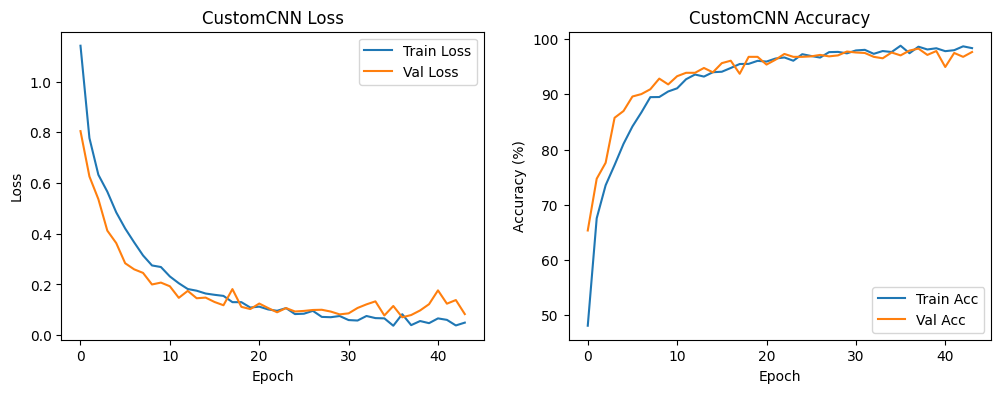

In [ ]:
plot_training_history(history, model_name="CustomCNN")

## **Loading the trained parameters (weights and biases) into our model architecture.**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best_brain_tumor_model.pth', map_location=device))
model.to(device)

BrainTumorCNN(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

## **Testing & Evaluation**

In [ ]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Loading best model for testing...
Test Accuracy: 98.17%

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.99      1.00      0.99       405
     notumor       0.99      0.96      0.97       300
  meningioma       0.95      0.97      0.96       306
      glioma       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



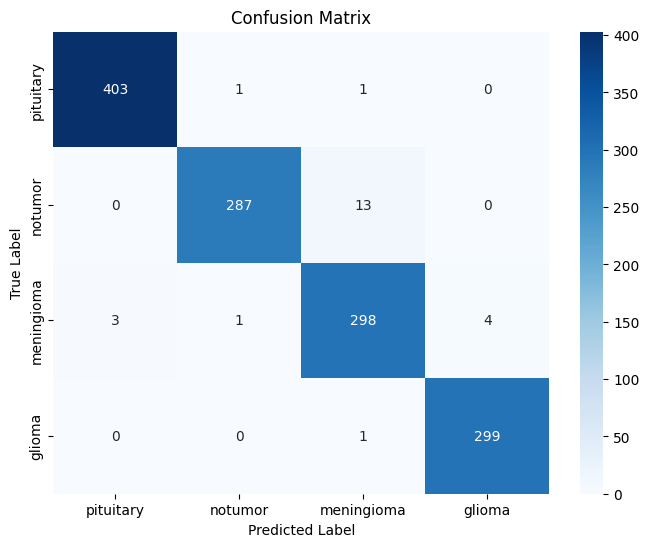

In [ ]:
print("\nLoading best model for testing...")
test_model(model, test_loader)

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(model, dataloader, num_classes, categories):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)

    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    # Binarize the labels
    all_labels_bin = label_binarize(all_labels, classes=range(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_outputs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()




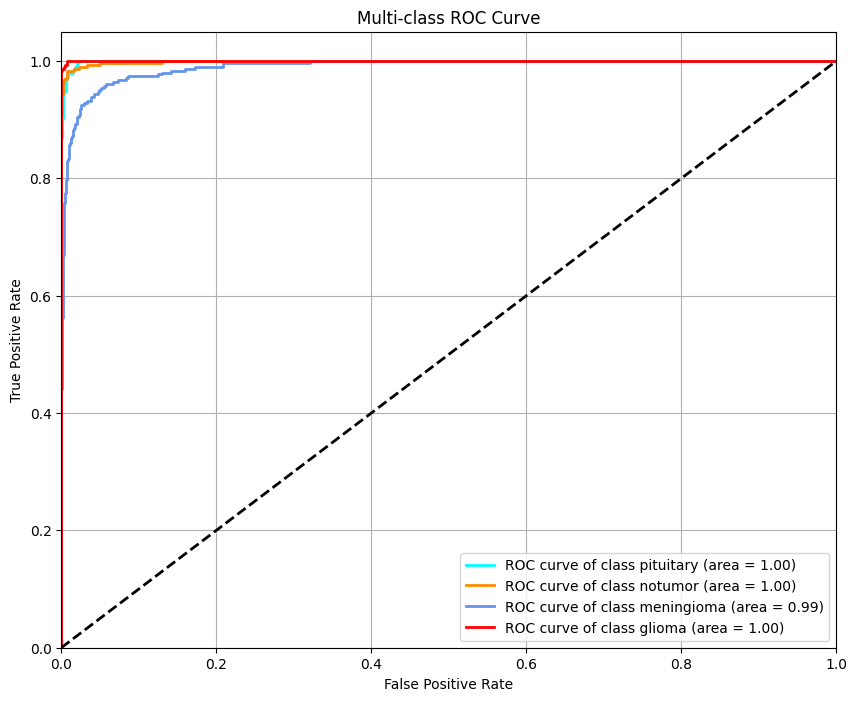

In [ ]:
plot_multiclass_roc(model, test_loader, num_classes=4, categories=categories)

In [ ]:
def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Separate correct and incorrect predictions
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())

    # Visualization
    # Unnormalize using your mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    num_cols = num_images // 2
    plt.figure(figsize=(15, 7))

    # Display correct predictions
    for i, img_tensor in enumerate(correct_images[:num_images // 2]):
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[correct_labels[i]]}\nPred: {categories[correct_preds[i]]}", color='green', fontsize=15)
        plt.axis('off')

    # Display incorrect predictions
    for i, img_tensor in enumerate(incorrect_images[:num_images // 2]):
        if i >= len(incorrect_images):
            plt.axis('off')
            continue
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[incorrect_labels[i]]}\nPred: {categories[incorrect_preds[i]]}", color='red', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


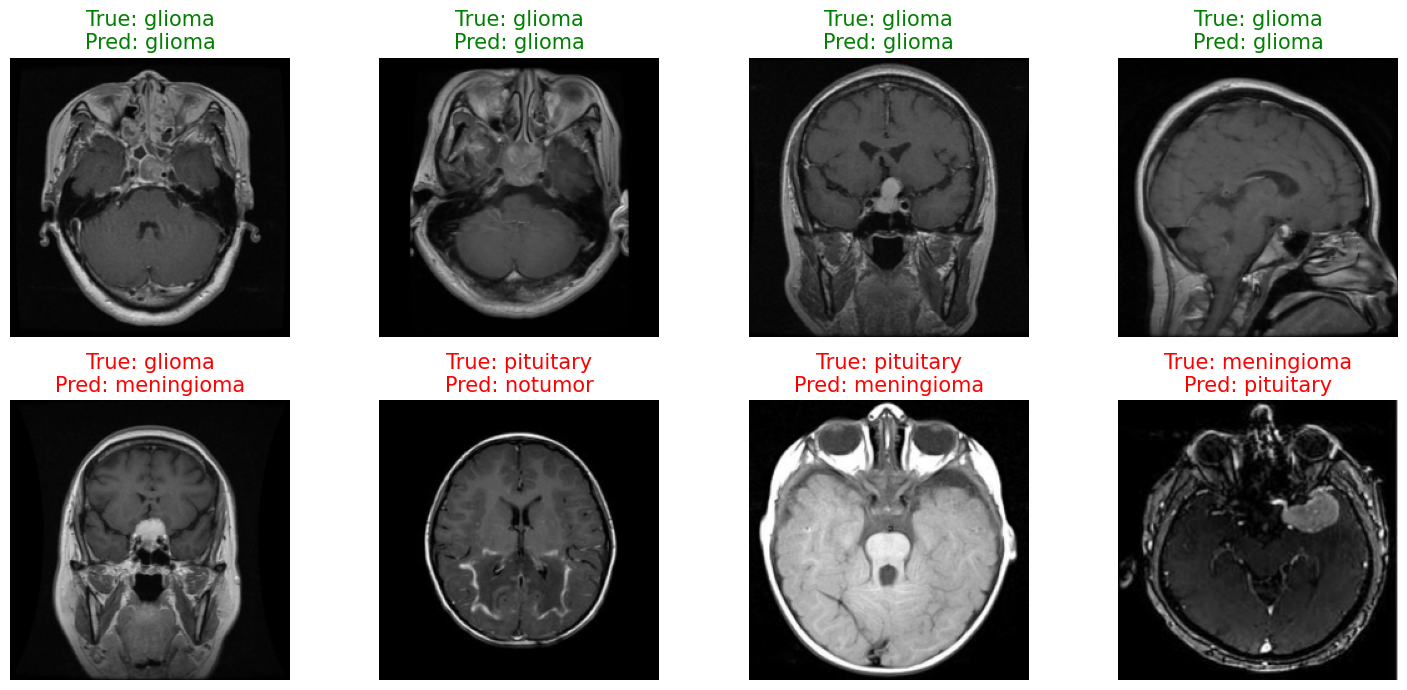

In [ ]:
visualize_predictions(model, test_loader, 8)

# **Model 2 (ResNet18)**

##  **Loading & Modifying the Pretrained ResNet-18 Model**

In [28]:
# Load pretrained ResNet-18 model
model2 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.6MB/s]


In [29]:
# Freeze all layers except the final fully connected layer
for param in model2.parameters():
    param.requires_grad = False

In [30]:
# Modifying the FC layer [(512->1000) to (512->4)]
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

In [31]:
# Move model to device
model2 = model2.to(device)

In [32]:
optimizer = optim.Adam(model2.fc.parameters(), lr=0.001)

## **Training (FC Layer Only)**

In [ ]:
print("Starting training...")
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='resnet18')

Starting training...
Epoch [1/60]
Train Loss: 0.6432, Train Accuracy: 75.27%
Val Loss: 0.3744, Val Accuracy: 87.58%
################################################################################
Epoch [2/60]
Train Loss: 0.4892, Train Accuracy: 81.13%
Val Loss: 0.3700, Val Accuracy: 85.83%
################################################################################
Epoch [3/60]
Train Loss: 0.4465, Train Accuracy: 83.21%
Val Loss: 0.3814, Val Accuracy: 84.60%
################################################################################
Epoch [4/60]
Train Loss: 0.4035, Train Accuracy: 84.66%
Val Loss: 0.2808, Val Accuracy: 89.24%
################################################################################
Epoch [5/60]
Train Loss: 0.3957, Train Accuracy: 84.61%
Val Loss: 0.3343, Val Accuracy: 87.58%
################################################################################
Epoch [6/60]
Train Loss: 0.3981, Train Accuracy: 84.50%
Val Loss: 0.2822, Val Accuracy: 89.50%
####

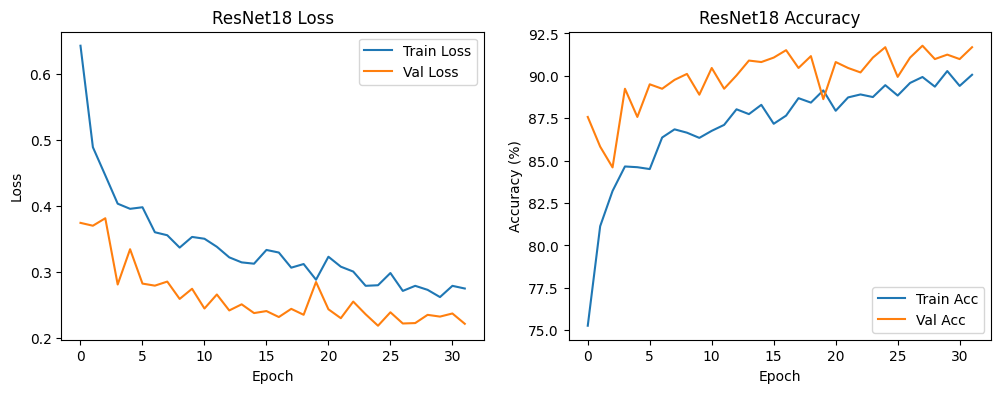

In [ ]:
plot_training_history(history, model_name="ResNet18")

## **Loading the trained parameters (weights and biases) into our model (ResNET18) architecture.**

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.load_state_dict(torch.load('best_brain_tumor_resnet18.pth', map_location=device))
model2 = model2.to(device)

## **Testing & Evaluation**


Loading best model for testing...
Test Accuracy: 89.32%

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.95      0.96      0.95       405
     notumor       0.93      0.79      0.86       300
  meningioma       0.77      0.84      0.80       306
      glioma       0.93      0.96      0.94       300

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.89      0.89      1311



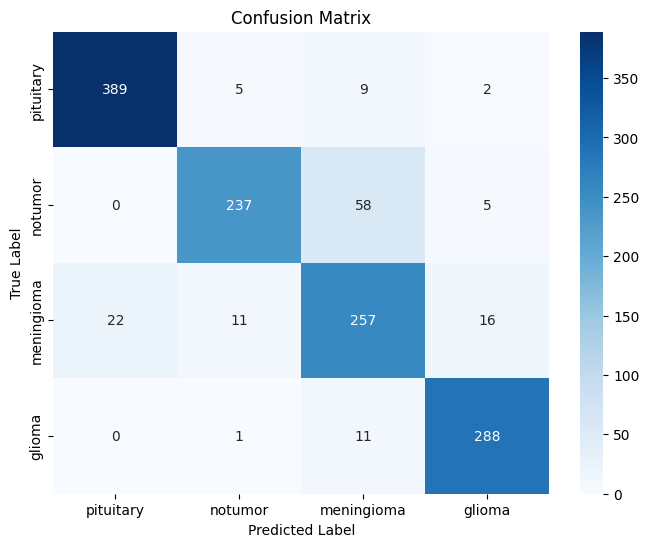

In [ ]:
print("\nLoading best model for testing...")
test_model(model2, test_loader)

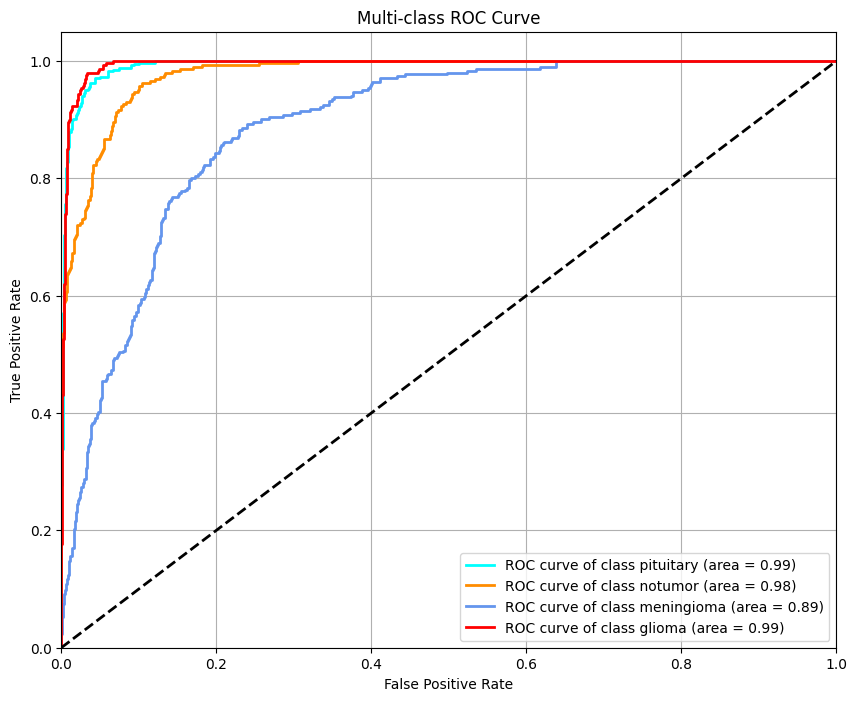

In [34]:
plot_multiclass_roc(model2, test_loader, num_classes=4, categories=categories)

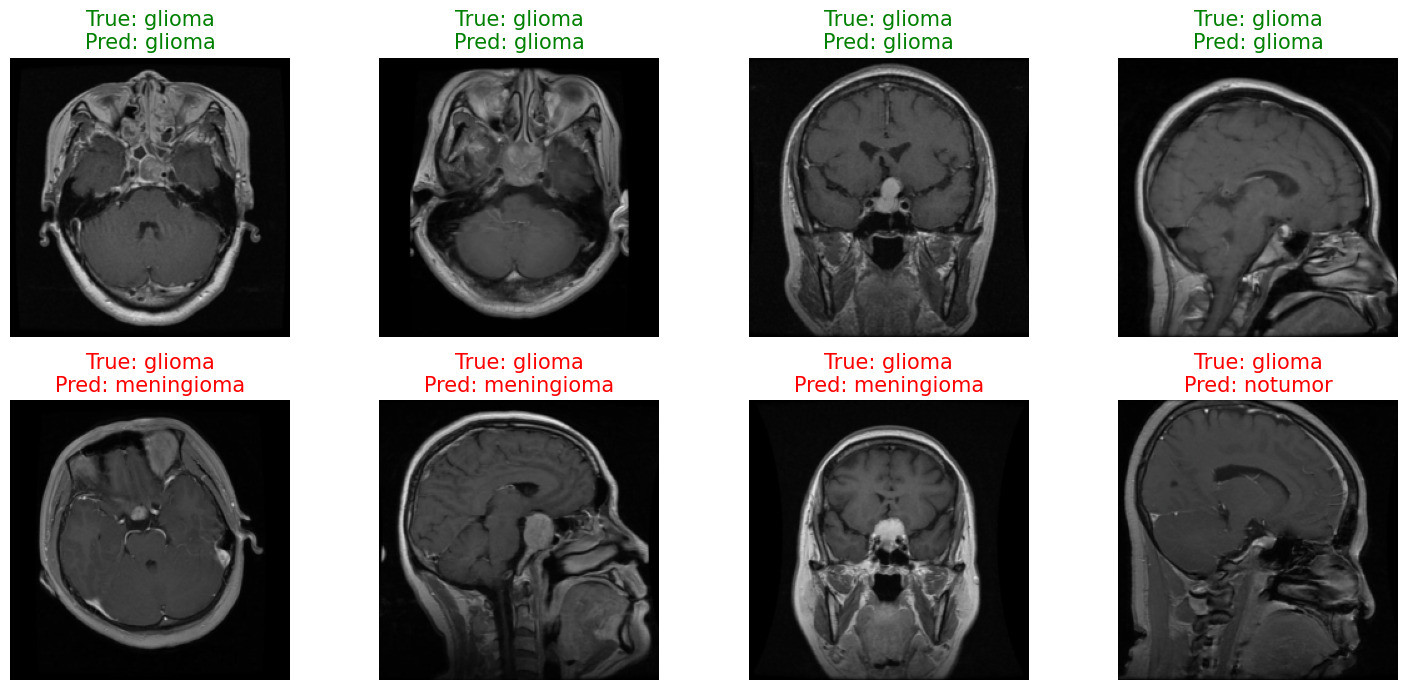

In [ ]:
visualize_predictions(model2, test_loader, 8)

## **FineTuning**

In [ ]:
# Unfreeze layer3, layer4 and fc
for name, param in model2.named_parameters():
    if 'layer4' in name or 'layer3' in name or 'fc' in name:
        param.requires_grad = True

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)

### **Training (Bolck3, Block4 and FC)**

In [ ]:
print("Starting training...")
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=30, name='resnet18_finetuned')

Starting training...
Epoch [1/30]
Train Loss: 0.2783, Train Accuracy: 89.71%
Val Loss: 0.2264, Val Accuracy: 90.73%
################################################################################
Epoch [2/30]
Train Loss: 0.2848, Train Accuracy: 89.65%
Val Loss: 0.2187, Val Accuracy: 91.69%
################################################################################
Epoch [3/30]
Train Loss: 0.2812, Train Accuracy: 89.21%
Val Loss: 0.2261, Val Accuracy: 91.43%
################################################################################
Epoch [4/30]
Train Loss: 0.2848, Train Accuracy: 89.84%
Val Loss: 0.2225, Val Accuracy: 91.51%
################################################################################
Epoch [5/30]
Train Loss: 0.2829, Train Accuracy: 89.63%
Val Loss: 0.2245, Val Accuracy: 91.16%
################################################################################
Epoch [6/30]
Train Loss: 0.2852, Train Accuracy: 89.54%
Val Loss: 0.2213, Val Accuracy: 91.25%
####

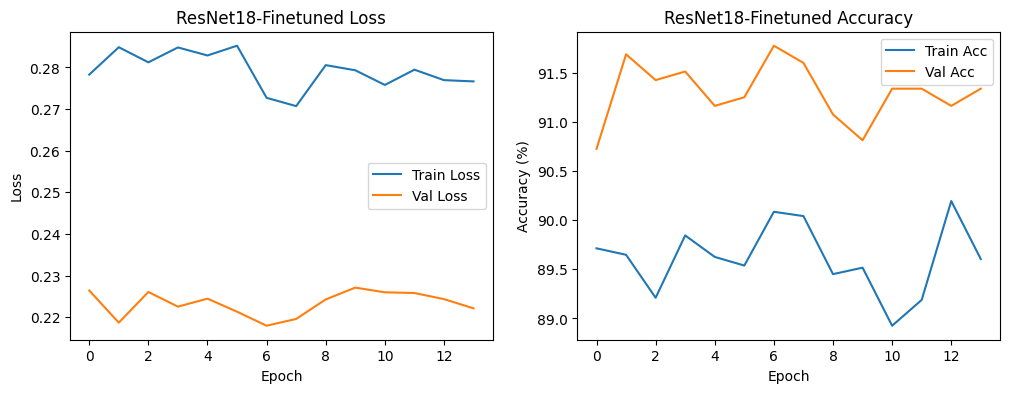

In [ ]:
plot_training_history(history, model_name="ResNet18-Finetuned")

### **Loading the trained parameters (weights and biases) into our model (ResNET18) architecture.**

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.load_state_dict(torch.load('best_brain_tumor_resnet18_finetuned.pth', map_location=device))
model2 = model2.to(device)

### **Testing & Evaluation**


Loading best model for testing...
Test Accuracy: 89.09%

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.95      0.96      0.96       405
     notumor       0.94      0.77      0.85       300
  meningioma       0.76      0.85      0.80       306
      glioma       0.92      0.96      0.94       300

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.89      0.89      1311



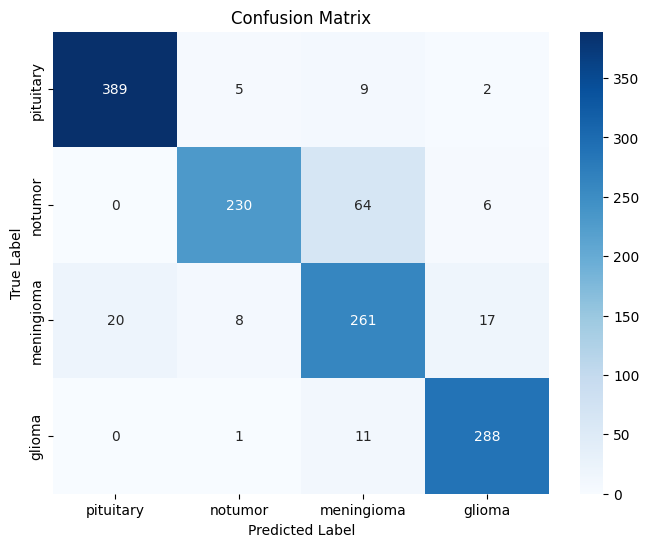

In [ ]:
print("\nLoading best model for testing...")
test_model(model2, test_loader)

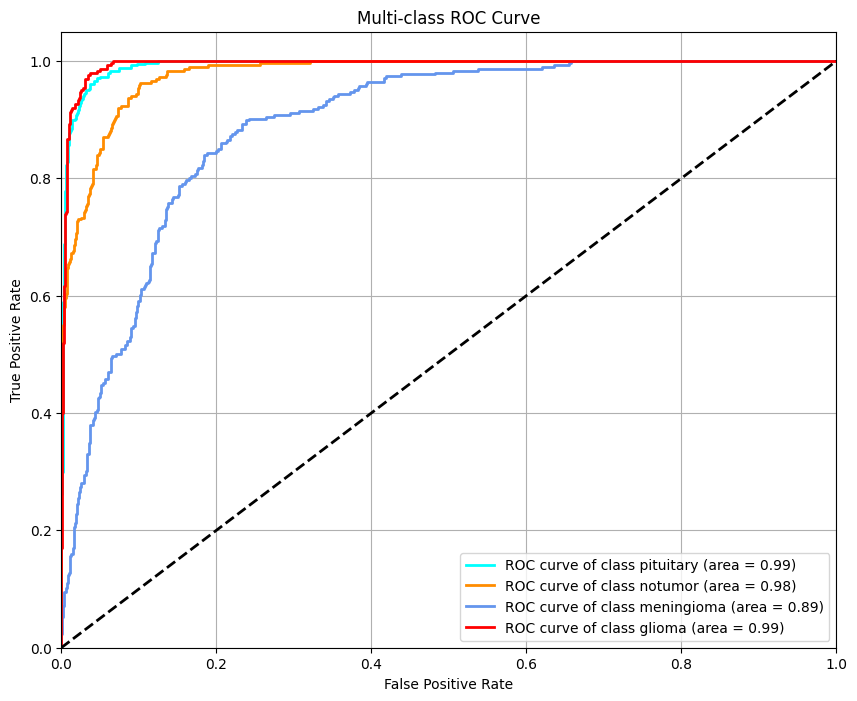

In [36]:
plot_multiclass_roc(model2, test_loader, num_classes=4, categories=categories)

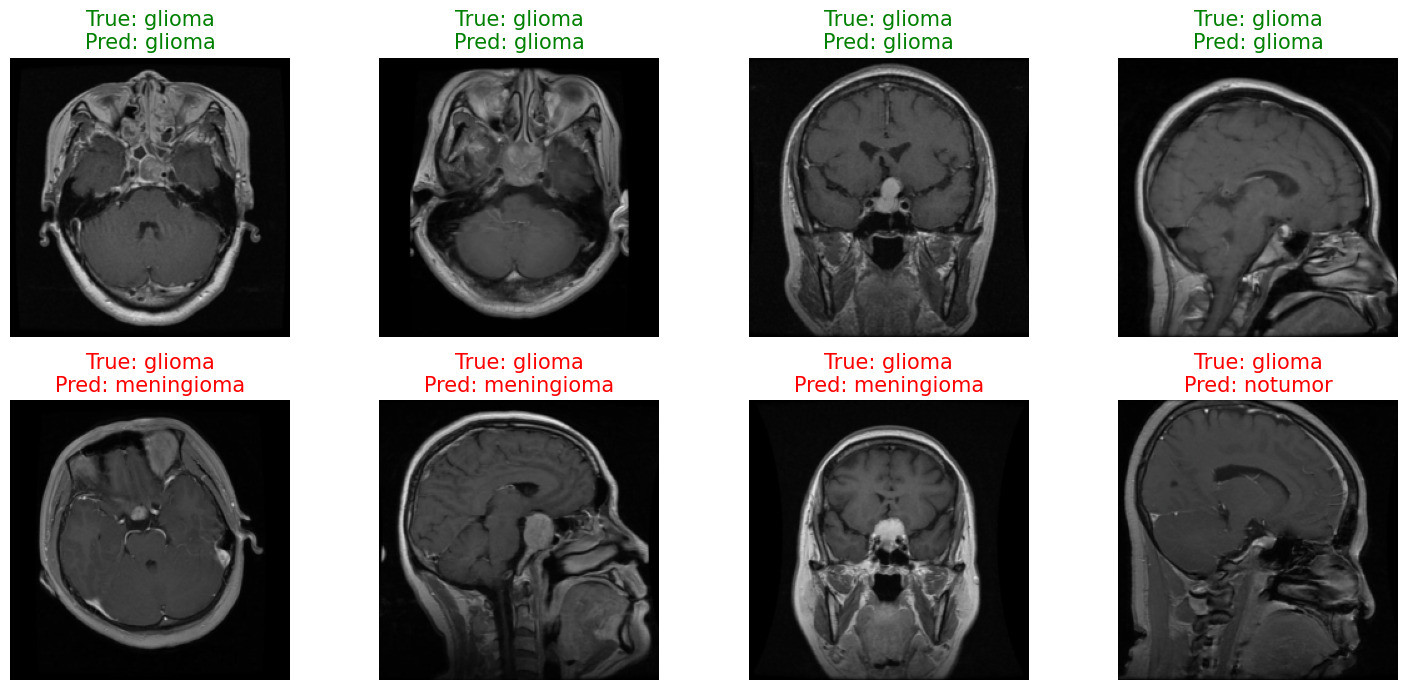

In [ ]:
visualize_predictions(model2, test_loader, 8)